In [6]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd_extra/")

# Location of masks and grid information for the model

# mask_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mask.nc")
# hgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_hgr.nc")
# zgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_zgr.nc")

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
#df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
#df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")

In [7]:
df = df_vent[['year_o','month_o','subvol_o']]
#df['year'] = datesandtime.sec_to_datetime_365day(df['time'],year0=1982, month0=12, day0=16)
df_group = df.groupby(['year_o','month_o'])
vol = df_group.sum()["subvol_o"].compute()

vol = vol.reset_index()
vol['date'] = pd.to_datetime( dict(year=vol.year_o, month=vol.month_o, day=1))
vol = vol.sort_values('date')
vol = vol.reset_index()

df_new = vol[vol['year_o']>1983]
df_group = df_new.groupby('month_o')
vol_period = df_group.mean()['subvol_o']
vol_period = vol_period.reset_index()

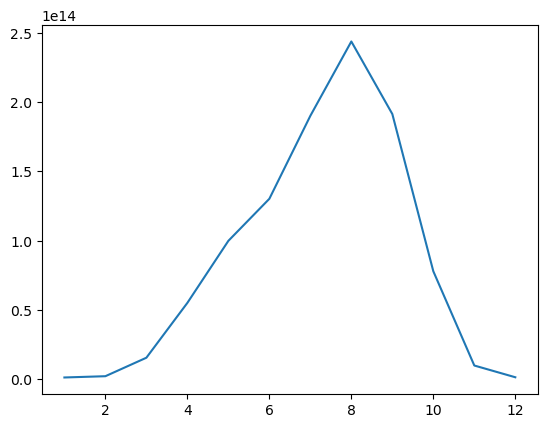

In [3]:

plt.plot(vol_period.month_o,vol_period.subvol_o)

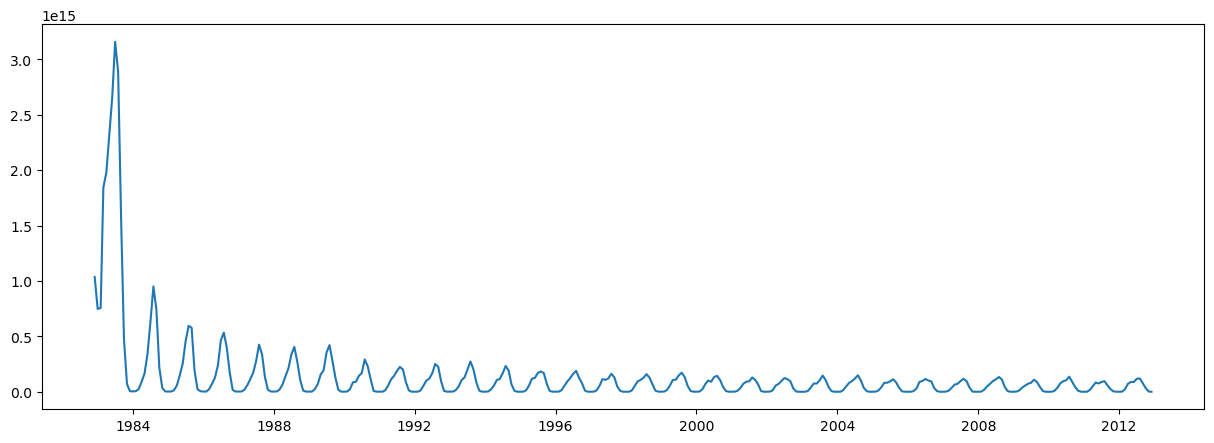

In [68]:
fig = plt.figure(figsize=(15,5))
plt.plot(vol['date'],vol.subvol_o)


In [32]:
##normalise vol
group_yr = vol.groupby(['year_o'])
max_vol = group_yr.max('subvol_o')


In [23]:
max_vol

,index,month_o,subvol_o
year_o,,,
1982,0,12,1.036173e+15
1983,176,12,3.157600e+15
1984,184,12,9.507043e+14
1985,192,12,5.949361e+14
1986,200,12,5.342818e+14
1987,204,12,4.252611e+14
1988,212,12,4.046392e+14
1989,216,12,4.209486e+14
1990,224,12,2.916453e+14


In [21]:
group_yr.head(5)

,index,year_o,month_o,subvol_o,date
0,0,1982,12,1.036173e+15,1982-12-01
1,1,1983,1,7.473684e+14,1983-01-01
2,173,1983,2,7.560677e+14,1983-02-01
3,174,1983,3,1.843531e+15,1983-03-01
4,2,1983,4,1.980335e+15,1983-04-01
...,...,...,...,...,...
349,165,2012,1,4.709183e+11,2012-01-01
350,357,2012,2,1.637501e+12,2012-02-01
351,358,2012,3,2.272076e+13,2012-03-01
352,166,2012,4,7.282485e+13,2012-04-01


In [33]:
vol_merg = vol.merge(max_vol,on='year_o')
vol_merg['norm'] = vol_merg.subvol_o_x/vol_merg.subvol_o_y


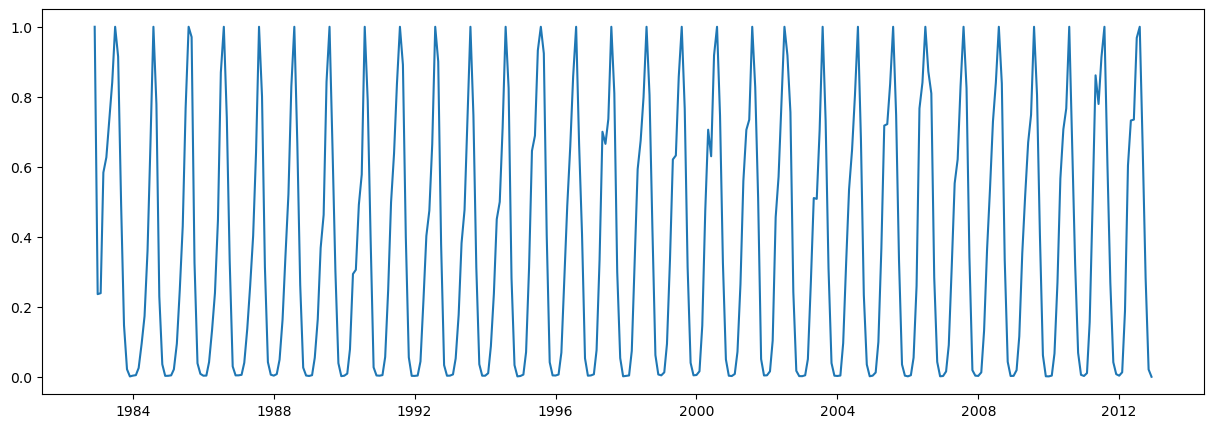

In [34]:
fig = plt.figure(figsize=(15,5))
plt.plot(vol_merg['date'],vol_merg.norm)


In [43]:
df_new = vol_merg[vol_merg['year_o']>1983]
df_group = df_new.groupby('month_o_x')
vol_period_norm = df_group.mean()['norm']
vol_period_norm = vol_period_norm.reset_index()

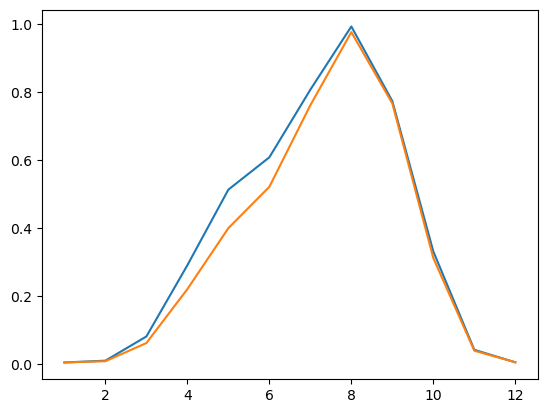

In [50]:
plt.plot(vol_period_norm.month_o_x,vol_period_norm.norm)
plt.plot(vol_period.month_o,vol_period.subvol_o/2.5e14)

In [3]:
##### 5 day pattern
df = df_vent[['year_o','month_o','subvol_o','dayofyear_o','day_o']]
#df['year'] = datesandtime.sec_to_datetime_365day(df['time'],year0=1982, month0=12, day0=16)
df_group = df.groupby(['year_o','month_o','dayofyear_o','day_o'])
vol = df_group.sum()["subvol_o"].compute()

vol = vol.reset_index()
vol['date'] = pd.to_datetime( dict(year=vol.year_o, month=vol.month_o, day=vol.day_o))
vol = vol.sort_values('date')
vol = vol.reset_index()

df_new = vol[vol['year_o']>1983]
df_group = df_new.groupby('dayofyear_o')
vol_period = df_group.mean()['subvol_o']
vol_period = vol_period.reset_index()

NameError: name 'df_vent' is not defined

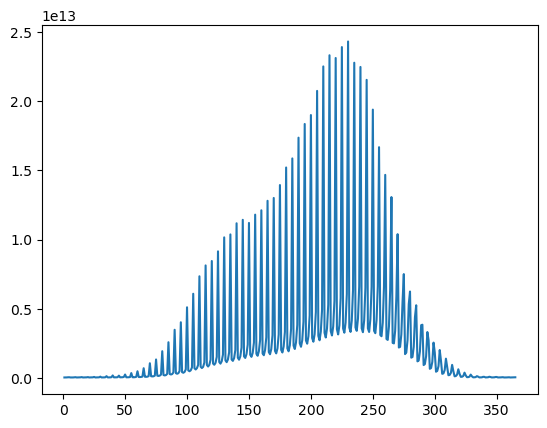

In [64]:
plt.plot(vol_period.dayofyear_o,vol_period.subvol_o)

In [ ]:
#######
# Now calculate Mix. Layer Depth (proxy)


In [8]:
df_finalz = df_vent[['z_o', 'year_o', 'month_o']]
df_group_z = df_finalz.groupby(['month_o','year_o'])
mean_z = df_group_z.mean()['z_o'].compute()
mean_z = mean_z.reset_index()
mean_z['date'] = pd.to_datetime( dict(year=mean_z.year_o, month=mean_z.month_o, day=1))
mean_z =mean_z.sort_values('date')
mean_z = mean_z.reset_index()

df_new = mean_z[mean_z['year_o']>1983]
df_group = df_new.groupby('month_o')
z_period = df_group.mean()['z_o']
z_period = z_period.reset_index()

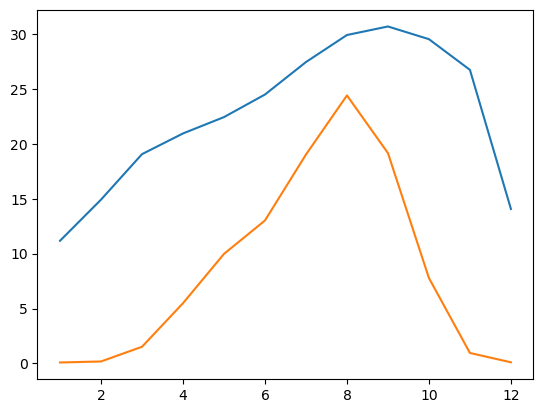

In [19]:
plt.plot(z_period.month_o,z_period.z_o)
plt.plot(vol_period.month_o,vol_period.subvol_o*1e-13)
#plt.plot(z_period.diff(periods=1).z_o)

In [ ]:
#find gradient of z_period
#for each point calculate gradient

In [16]:
z_period.diff(periods=1)

,month_o,z_o
0,NaN,NaN
1,1.0,3.744953
2,1.0,4.142212
3,1.0,1.883648
4,1.0,1.489860
5,1.0,2.054866
6,1.0,2.955539
7,1.0,2.462405
8,1.0,0.776951
9,1.0,-1.155586


In [9]:
mean_z['grad'] = mean_z['z_o'].diff(periods=1)
mean_z_pos = mean_z[mean_z['grad']>0]

In [5]:
mean_z_pos

,index,month_o,year_o,z_o,date,grad
1,0,1,1983,14.979118,1983-01-01,0.973262
2,190,2,1983,15.718294,1983-02-01,0.739176
3,203,3,1983,18.320441,1983-03-01,2.602147
4,47,4,1983,20.650944,1983-04-01,2.330503
5,60,5,1983,23.357847,1983-05-01,2.706903
...,...,...,...,...,...,...
352,59,4,2012,21.561161,2012-04-01,1.581504
353,72,5,2012,22.702076,2012-05-01,1.140915
354,85,6,2012,24.738732,2012-06-01,2.036656
355,279,7,2012,27.281162,2012-07-01,2.542430


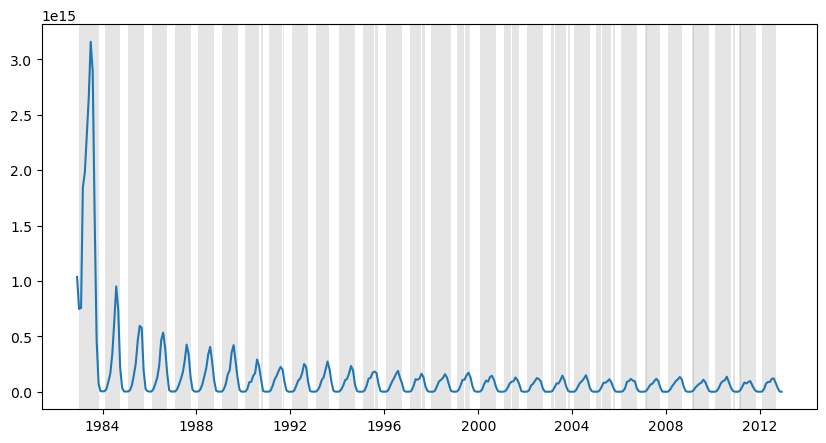

In [15]:
fig = plt.figure(figsize=(10,5))
plt.plot(vol['date'],vol.subvol_o)

highlight_dates = mean_z[mean_z['grad']>0]['date']
for date in highlight_dates:
    plt.axvspan(date, date + pd.Timedelta(days=30), color='k', alpha=0.1, lw=0)




#plt.plot(mean_z_pos['date'],mean_z_pos['grad'])


In [22]:
total

np.float64(4.8980915563302936e+16)

In [23]:
#now subset by dates in positive grad region
mean_z_pos = mean_z[mean_z['grad']>0]
merge_vol_pos = mean_z_pos.merge(vol,on='date')


In [26]:
total = vol['subvol_o'].sum()
pos_total=merge_vol_pos['subvol_o'].sum()

In [28]:
total

np.float64(4.8980915563302936e+16)

In [31]:
(pos_total)/total

np.float64(0.9135027776570963)

In [35]:
##### using normalised volumes:
merge_vol_pos_norm = mean_z_pos.merge(vol_merg,on='date')

In [36]:
total = vol_merg['norm'].sum()

pos_total_norm=merge_vol_pos_norm['norm'].sum()

In [37]:
total

np.float64(135.91437998096671)

In [38]:
pos_total_norm

np.float64(121.29681476233569)

In [39]:
pos_total_norm/total

np.float64(0.8924501938597075)